In [1]:
import numpy as np
import pandas as pd
import os
import time
import copy
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils

import torchvision
from torchvision import datasets, models
from torchvision.models.detection import KeypointRCNN, backbone_utils, keypointrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Prefix data directory
prefix_dir = '.'

# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
train_dir = f'{prefix_dir}/data/train_imgs'

# Number of classes in the dataset
num_classes = 48

# Batch size for training (change depending on how much memory you have)
batch_size = 64

num_earlystop = 10

# input size, input_size=w=h
input_size = 128

# Learning rate for optimizer
learning_rate = 0.01

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [3]:
df = pd.read_csv(f'{prefix_dir}/data/train_df.csv')
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [4]:
imgs = df.iloc[:, 0].to_numpy()
motions = df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
keypoints = []
for motion in motions.to_numpy():
    a_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_keypoints.append((float(motion[i]), float(motion[i+1])))
    keypoints.append(a_keypoints)
keypoints = np.array(keypoints)

In [5]:
class_labels, keypoints[0]

(['nose',
  'left_eye',
  'right_eye',
  'left_ear',
  'right_ear',
  'left_shoulder',
  'right_shoulder',
  'left_elbow',
  'right_elbow',
  'left_wrist',
  'right_wrist',
  'left_hip',
  'right_hip',
  'left_knee',
  'right_knee',
  'left_ankle',
  'right_ankle',
  'neck',
  'left_palm',
  'right_palm',
  'spine2(back)',
  'spine1(waist)',
  'left_instep',
  'right_instep'],
 array([[1046.38963083,  344.75788121],
        [1041.65529436,  329.82022504],
        [1059.42950724,  334.48422953],
        [1020.11779614,  338.89053933],
        [1048.        ,  343.        ],
        [ 992.        ,  394.        ],
        [1054.        ,  400.        ],
        [ 956.        ,  368.        ],
        [1134.        ,  371.        ],
        [1003.49724232,  327.64008508],
        [1078.        ,  341.        ],
        [ 999.        ,  570.        ],
        [1046.        ,  573.        ],
        [ 995.        ,  695.        ],
        [1054.        ,  698.        ],
        [ 983.      

In [6]:
columns = df.iloc[:, 1:].columns.to_list()
xmax, xmin = 0, 999999999
ymax, ymin = 0, 999999999
# print(columns)
for column in columns:
    if '_x' in column:
        if df[column].max() > xmax:
            xmax = df[column].max()
        if df[column].min() < xmin:
            xmin = df[column].min()
    if '_y' in column:
        if df[column].max() > ymax:
            ymax = df[column].max()
        if df[column].min() < ymin:
            ymin = df[column].min()
print(xmin, ymin, xmax, ymax)
print(xmin*0.95, ymin*0.95, xmax*1.05, ymax*1.05)

AttributeError: 'Series' object has no attribute 'columns'

In [22]:
x1, y1, x2, y2 = keypoints[0][:, 0].min(), keypoints[0][:, 1].min(), keypoints[0][:, 0].max(), keypoints[0][:, 1].max()
x1, y1, x2, y2 = int(x1 * 0.95), int(y1 * 0.95), int(x2 * 1.05), int(y2 * 1.05)
x1, y1, x2, y2

(908, 300, 1190, 880)

In [30]:
keypoints[0][:, 0] -= x1
keypoints[0][:, 1] -= y1

NameError: name 'x' is not defined

In [31]:
keypoints[0]

array([[138.38963083,  44.75788121],
       [133.65529436,  29.82022504],
       [151.42950724,  34.48422953],
       [112.11779614,  38.89053933],
       [140.        ,  43.        ],
       [ 84.        ,  94.        ],
       [146.        , 100.        ],
       [ 48.        ,  68.        ],
       [226.        ,  71.        ],
       [ 95.49724232,  27.64008508],
       [170.        ,  41.        ],
       [ 91.        , 270.        ],
       [138.        , 273.        ],
       [ 87.        , 395.        ],
       [146.        , 398.        ],
       [ 75.        , 520.        ],
       [134.        , 529.        ],
       [111.10727706,  73.7662215 ],
       [105.13735959,  16.31169501],
       [159.        ,  35.        ],
       [111.48422953, 155.        ],
       [118.51577047, 214.05473034],
       [ 90.57883627, 526.71801285],
       [155.20406742, 538.82746548]])

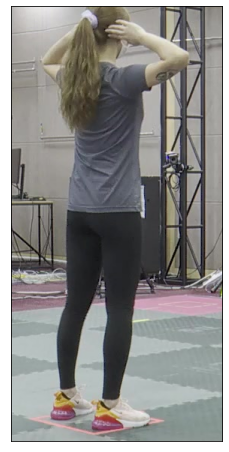

In [23]:
cropped_img = img[y1:y2, x1:x2]

plt.figure(figsize=(12,8))
plt.imshow(cropped_img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [25]:
resized_img = cropped_img.resize(128, 128)

plt.figure(figsize=(12,8))
plt.imshow(resized_img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

ValueError: resize only works on single-segment arrays

In [17]:
def vis_keypoints(image, keypoints, color=(0, 255, 0), diameter=2):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
        
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(image)

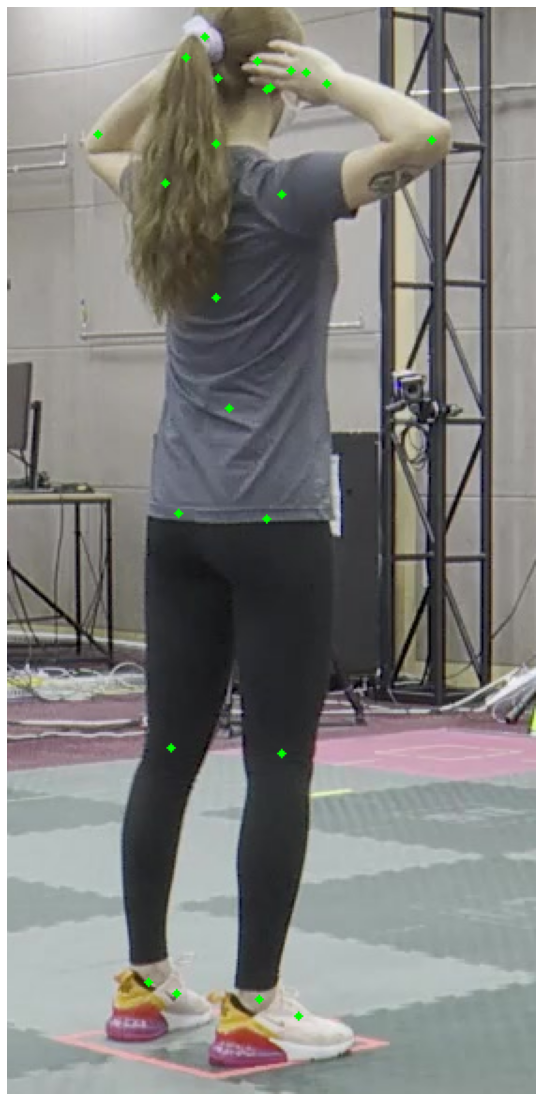

In [43]:
vis_keypoints(cropped_img, keypoints[0])

In [44]:
# (150, 460, 1015, 1510)
# # Data augmentation and normalization for training
# # Just resize and normalization for validation
A_transforms = A.Compose([
    A.Resize(128, 128),
#     A.RandomBrightnessContrast(p=0.5),
#     A.OneOf([A.HorizontalFlip(p=1),
#              A.RandomRotate90(p=1),
#              A.VerticalFlip(p=1)            
#     ], p=0.5),
#     A.OneOf([A.MotionBlur(p=1),
#              A.GaussNoise(p=1)                 
#     ], p=0.5),
#     A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True))

In [45]:
after = A_transforms(image=cropped_img, keypoints=keypoints[0], class_labels=class_labels)
after_img = after['image']
after_keys = after['keypoints']
print(after_img.shape)
print(after_keys)

(128, 128, 3)
[(62.81515158197571, 9.877601371162871), (60.66623290035839, 6.581015181822144), (68.73396073150488, 7.610312723174113), (50.89034718220774, 8.5827397132183), (63.54609929078014, 9.489655172413793), (38.12765957446808, 20.744827586206895), (66.26950354609929, 22.06896551724138), (21.78723404255319, 15.006896551724138), (102.58156028368793, 15.668965517241379), (43.34626601883462, 6.09988084464119), (77.16312056737588, 9.048275862068966), (41.30496453900709, 59.58620689655172), (62.638297872340424, 60.248275862068965), (39.48936170212766, 87.17241379310344), (66.26950354609929, 87.8344827586207), (34.04255319148936, 114.75862068965517), (60.82269503546099, 116.7448275862069), (50.43167185890317, 16.279441986775318), (47.721922082423994, 3.5998223463476187), (72.17021276595744, 7.724137931034482), (50.60277084908156, 34.206896551724135), (53.79439227148587, 47.23966462614947), (41.11379802402443, 116.24121662951265), (70.44723627541597, 118.913647554208)]


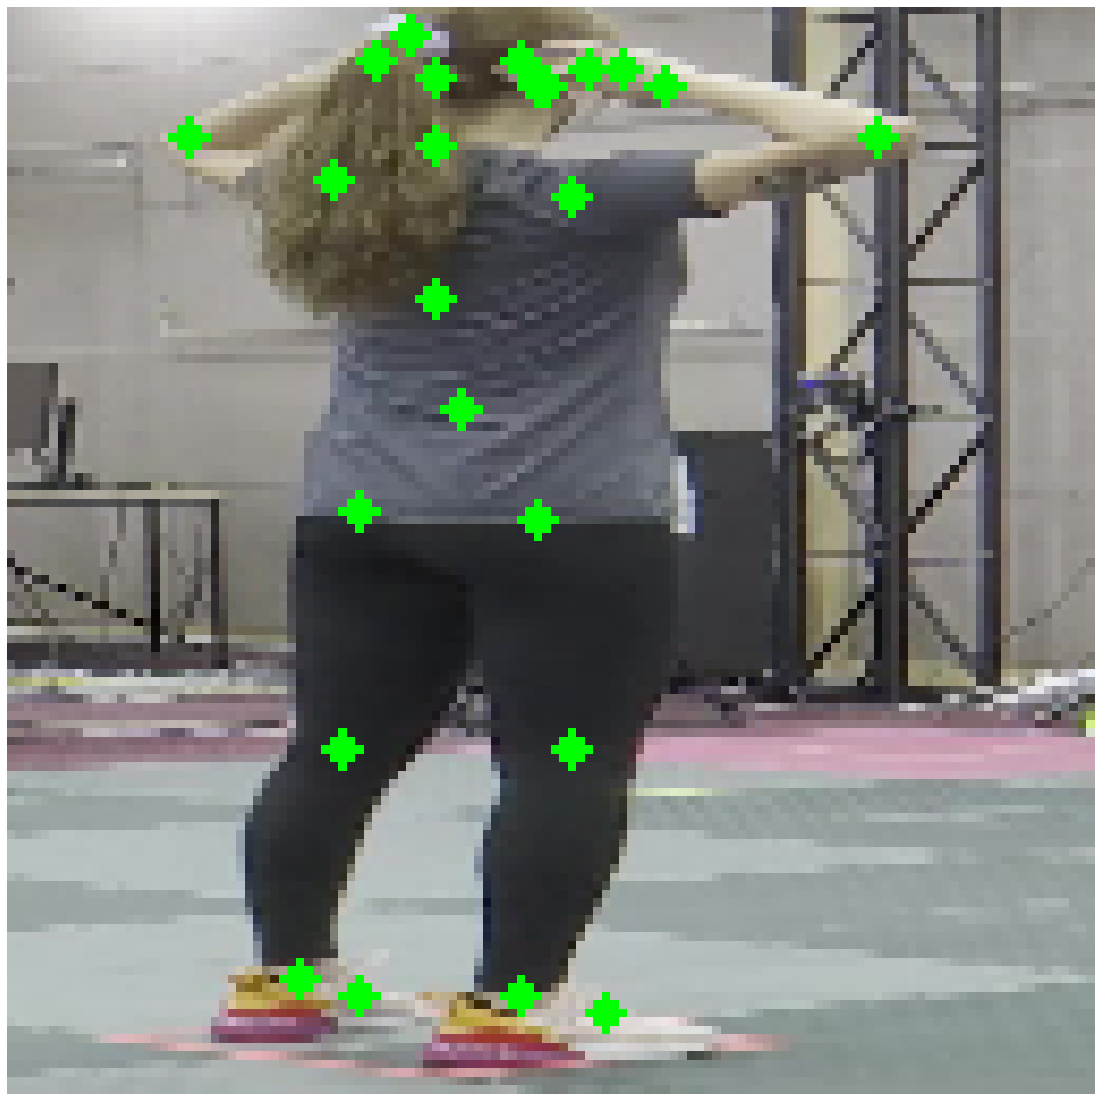

In [46]:
vis_keypoints(after_img, after_keys)

In [20]:
# # Data augmentation and normalization for training
# # Just resize and normalization for validation

A_transforms = A.Compose([
            A.Resize(input_size, input_size, always_apply=True),
            A.RandomBrightnessContrast(p=0.3),
            A.HorizontalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.VerticalFlip(p=0.3),
            A.MotionBlur(p=0.3),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#             ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy'))

In [21]:
idx = 0
img = cv2.imread(os.path.join(train_dir, imgs[idx]), cv2.COLOR_BGR2RGB)
print(img.shape)
x1, y1 = keypoints[idx][:, 0].min(), keypoints[idx][:, 1].min()
x2, y2 = keypoints[idx][:, 0].max(), keypoints[idx][:, 1].max()
print(x1, y1, x1, x2)
print(keypoints[idx])
print(class_labels)
bboxes = np.array([[x1, y1, x2, y2]], dtype=int)
labels = np.array([1], dtype=int)
targets = {
    'image': img,
    'bboxes': bboxes,
    'labels': labels, # human is 1, 0 is background
    'keypoints': keypoints[idx],
#     'class_labels': class_labels
}

# targets = A_transforms(image=img, keypoints=keypoints[0], class_labels=class_labels)
targets = A_transforms(**targets)
img = targets['image']

print(targets['keypoints'])
targets = {
    'labels': targets['labels'],
    'boxes': targets['bboxes'],
    'keypoints': np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis]
}

(1080, 1920, 3)
956.0 316.31169500688765 956.0 1134.0
[[1046.38963083  344.75788121]
 [1041.65529436  329.82022504]
 [1059.42950724  334.48422953]
 [1020.11779614  338.89053933]
 [1048.          343.        ]
 [ 992.          394.        ]
 [1054.          400.        ]
 [ 956.          368.        ]
 [1134.          371.        ]
 [1003.49724232  327.64008508]
 [1078.          341.        ]
 [ 999.          570.        ]
 [1046.          573.        ]
 [ 995.          695.        ]
 [1054.          698.        ]
 [ 983.          820.        ]
 [1042.          829.        ]
 [1019.10727706  373.7662215 ]
 [1013.13735959  316.31169501]
 [1067.          335.        ]
 [1019.48422953  455.        ]
 [1026.51577047  514.05473034]
 [ 998.57883627  826.71801285]
 [1063.20406742  838.82746548]]
['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee

In [22]:
def vis_keypoints2(image, keypoints, bbox, color=(0, 255, 0), diameter=2):
    image = image.copy()
    print(image.shape)

    for k in keypoints[0]:
        x = k[0]
        y = k[1]
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
    bbox = bbox[0]
    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 100, 91), thickness=2)
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(image)

In [23]:
targets

{'labels': [1],
 'boxes': [(37.45185185185185,
   52.400000000000006,
   99.31851851851852,
   64.26666666666667)],
 'keypoints': array([[[40.86019333, 57.24069128,  1.        ],
         [39.08980445, 57.55631371,  1.        ],
         [39.64257535, 56.37136618,  1.        ],
         [40.16480466, 58.99214692,  1.        ],
         [40.65185185, 57.13333333,  1.        ],
         [46.6962963 , 60.86666667,  1.        ],
         [47.40740741, 56.73333333,  1.        ],
         [43.61481481, 63.26666667,  1.        ],
         [43.97037037, 51.4       ,  1.        ],
         [38.83141749, 60.10018385,  1.        ],
         [40.41481481, 55.13333333,  1.        ],
         [67.55555556, 60.4       ,  1.        ],
         [67.91111111, 57.26666667,  1.        ],
         [82.37037037, 60.66666667,  1.        ],
         [82.72592593, 56.73333333,  1.        ],
         [97.18518519, 61.46666667,  1.        ],
         [98.25185185, 57.53333333,  1.        ],
         [44.29821884

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


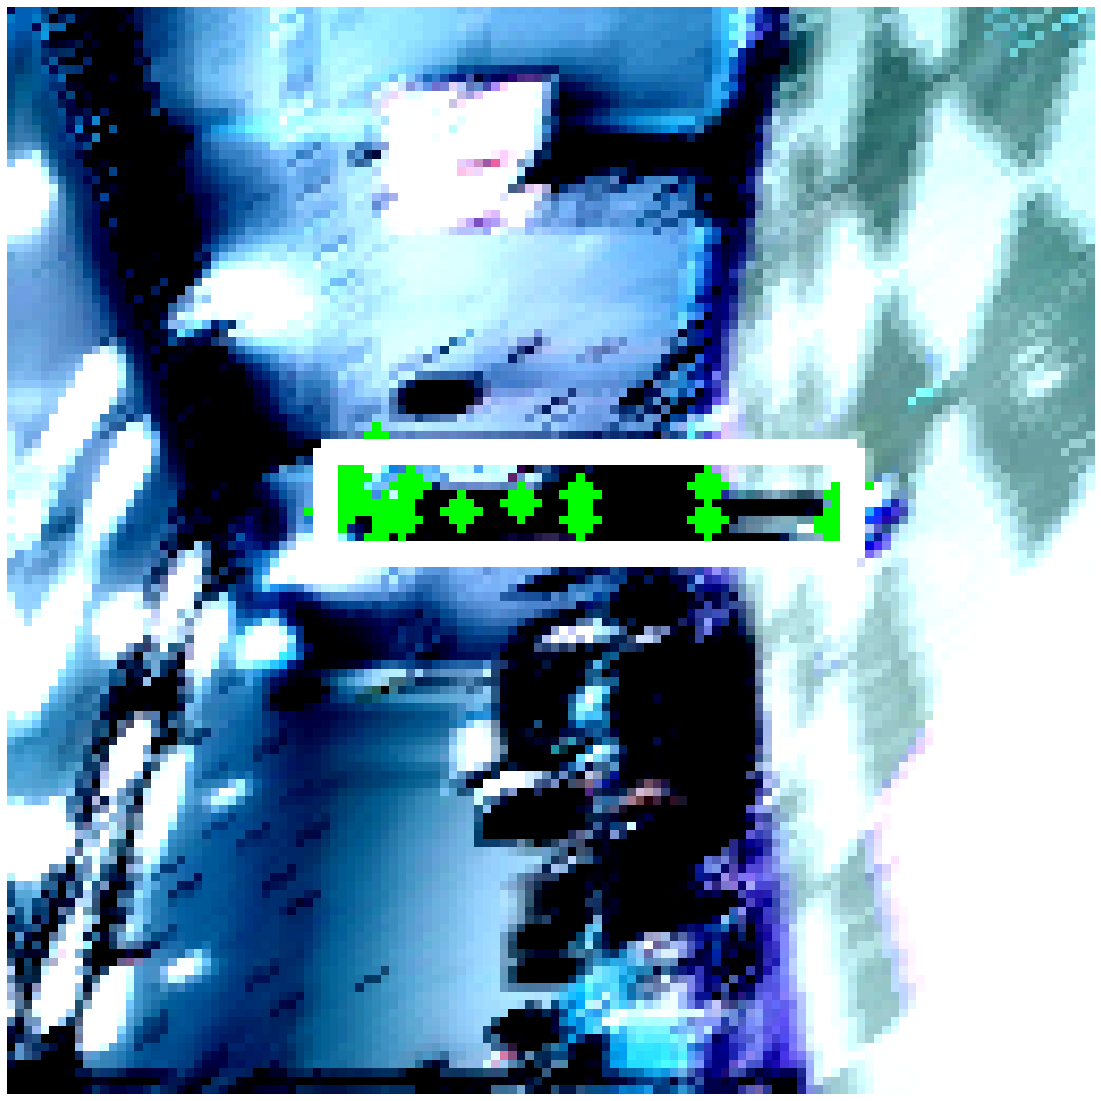

In [24]:
vis_keypoints2(img, targets['keypoints'], targets['boxes'])